In [113]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph
from torch_geometric.nn import GCNConv, GATConv, TopKPooling
from torch.functional import F
from typing import Type
import random
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from itertools import count

files = ["./data/data_classA.h5", "./data/data_classB.h5", "./data/data_classC.h5", 
        "./data/data_classD.h5", "./data/data_classE.h5", "./data/data_classF.h5", 
        "./data/data_classG.h5", "./data/data_classH.h5"]


# Definition of graph neural network

In [114]:
class GCN(nn.Module):
    """
    Graph Convolutional Network (GCN) model.
    
    Args:
        input_dim (int): Dimensionality of the input features.
        hidden_dim (int): Dimensionality of the hidden layers.
        output_dim (int): Dimensionality of the output layer.
        num_layers (int): Number of GCN layers in the model.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        # Initialize a list of layers
        self.layers = nn.ModuleList()
        # Add the first layer (input to hidden)
        self.layers.append(GCNConv(input_dim, hidden_dim))
        # Add hidden layers (hidden to hidden)
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_dim, hidden_dim))
        # Add the final layer (hidden to output)
        self.layers.append(GCNConv(hidden_dim, output_dim))

        self.num_layers = num_layers

        self.transform = torch.nn.Linear(input_dim, hidden_dim)

    def forward(self, x, edge_index):
        """
        Forward pass of the GCN model.
        
        Args:
            x (Tensor): Input feature matrix.
            edge_index (Tensor): Graph edge indices.
        
        Returns:
            Tensor: Log-softmax output of the model.
        """
        #Applying skip connection
        first_x = self.transform(x)


        # Apply each layer except the last one with ReLU activation
        for i, layer in enumerate(self.layers):
            if i != 0:
                x = x + first_x

            x = layer(x, edge_index)

            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, 0.25, training=self.training)
        # Apply the last layer without activation, followed by log softmax
        return F.log_softmax(x, dim=1)



# GAT Network

In [115]:
class GAT(nn.Module):
    """
    Graph Convolutional Network (GAT) model.
    
    Args:
        input_dim (int): Dimensionality of the input features.
        hidden_dim (int): Dimensionality of the hidden layers.
        output_dim (int): Dimensionality of the output layer.
        num_layers (int): Number of GCN layers in the model.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, heads=1):
        super().__init__()
        # Initialize a list of layers
        self.layers = nn.ModuleList()
        # Add the first layer (input to hidden)
        self.layers.append(GATConv(input_dim, hidden_dim, heads=heads))
        # Add hidden layers (hidden to hidden)
        for _ in range(num_layers - 2):
            self.layers.append(GATConv(hidden_dim * heads, hidden_dim, heads=heads))
        # Add the final layer (hidden to output)
        self.layers.append(GATConv(hidden_dim * heads, output_dim, heads=heads))

        self.num_layers = num_layers

        self.transform = torch.nn.Linear(input_dim, hidden_dim * heads)

    def forward(self, x, edge_index):
        """
        Forward pass of the GCN model.
        
        Args:
            x (Tensor): Input feature matrix.
            edge_index (Tensor): Graph edge indices.
        
        Returns:
            Tensor: Log-softmax output of the model.
        """
        #Applying skip connection
        first_x = self.transform(x)


        # Apply each layer except the last one with ReLU activation
        for i, layer in enumerate(self.layers):
            if i != 0:
                x = x + first_x

            x = layer(x, edge_index)

            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, 0.25, training=self.training)
        # Apply the last layer without activation, followed by log softmax
        return F.log_softmax(x, dim=1)



In [116]:
def train_model(
    model_cls: Type[nn.Module],
    graph: Data,
    n_epochs: int = 10,
    model_args = tuple(),
    model_kwargs = dict(),
    *,
    get_optim=lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9, centered=True),
    get_loss_fn=lambda model: nn.CrossEntropyLoss()
):
    """
    Train the GCN model on the provided graph data.
    
    Args:
        model_cls (Type[nn.Module]): Class of the model to be trained.
        graph (Data): Graph data containing features, edge indices, and labels.
        n_epochs (int, optional): Number of training epochs. Default is 10.
        model_args (tuple, optional): Positional arguments for the model initialization. Default is an empty tuple.
        model_kwargs (dict, optional): Keyword arguments for the model initialization. Default is an empty dictionary.
        get_optim (function, optional): Function that returns the optimizer. Default is Adam optimizer with lr=0.001.
        get_loss_fn (function, optional): Function that returns the loss function. Default is CrossEntropyLoss.
    
    Returns:
        Tuple[nn.Module, list, list]: Trained model, accuracy plot data, and loss plot data.
    """
    # Move the graph data to the GPU
    graph = graph.cuda()
    # Instantiate the model and move it to the GPU
    model = model_cls(*model_args, **model_kwargs).cuda()
    # Get the loss function
    loss_fn = get_loss_fn(model)
    # Get the optimizer
    optimizer = get_optim(model)
    # Lists to store accuracy and loss for plotting
    accuracy_plot = []
    loss_plot = []
    
    # Training loop
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        optimizer.zero_grad()  # Zero the gradients
        out = model(graph.x, graph.edge_index)  # Forward pass
        # Compute the loss for the training set
        loss = loss_fn(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()  # Backward pass
        optimizer.step()  # Update the model parameters
        
        model.eval()  # Set the model to evaluation mode
        # Predict and compute accuracy on the training set
        pred = model(graph.x, graph.edge_index).argmax(dim=1)
        acc = (pred[graph.train_mask] == graph.y[graph.train_mask]).float().mean()
        # Append accuracy and loss for every 10 epochs
        # if epoch % 10 == 0:
        accuracy_plot.append(acc.item())
        loss_plot.append(loss.item())
        print(f"Epoch {epoch} | Loss: {loss.item():.3f} | Accuracy: {acc.item():.2%}")
    
    model.eval()  # Final evaluation mode
    return model, accuracy_plot, loss_plot  # Return the model and plot data

# Data loading

In [117]:
# Initialize a counter variable 'i' to assign class labels starting from 1
i = 1
# Initialize an empty list 'arr' to store individual dataframes
arr = []
graph_arr = []

# Iterate over the list of files
for f in files:
    # Read the HDF5 file into a dataframe
    df = pd.read_hdf(f, "y")
    # Insert a new column 'particle_class' at position 9 with the value of 'i'
    df.insert(9, "particle_class", i, True)
    # Append the modified dataframe to the list 'arr'
    graph_arr.append(df[:3])
    arr.append(df)
    # Increment the counter variable 'i' for the next file
    i += 1

# Concatenate all dataframes in the list 'arr' into a single dataframe
df_empty = pd.concat(arr)
# Print the number of rows in the concatenated dataframe
print(df_empty.shape[0])

14597


## Creating data for example graph

In [118]:
df_showcase = pd.concat(graph_arr)

print(np.array(df_showcase['particle_class']))

[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]


## Data normalization

In [119]:
# Initialize the MinMaxScaler
scaler = StandardScaler()

# Drop the 'particle_class' column from the dataframe 'df_empty'
# This is done to ensure that the 'particle_class' column is not included in the normalization

df = df_empty.drop('particle_class', axis=1)

# Fit the scaler to the dataframe (excluding the 'particle_class' column) and transform it
# The result is an array with values scaled to the range [0, 1]
# Convert the array back to a DataFrame
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
print(df_showcase)
df_1 = df_showcase.drop('particle_class', axis=1)
df_showcase_normalized = pd.DataFrame(scaler.fit_transform(df_1), columns=df_1.columns)

         x1        x2        x3          x4          x5          x6  \
0 -0.330453  0.929098 -0.166064  452.811567  529.441053   62.755895   
1  0.946442  0.217871 -0.238286  447.787789  567.630889  200.717983   
2  0.114273 -0.873835  0.472603  465.967038  570.088884  103.696301   
0  0.311957  0.945305 -0.095297  473.529680  527.515439  115.835923   
1 -0.353569 -0.922056  0.157483  449.993796  588.855181  153.173299   
2  0.842615  0.274762  0.463148  443.563794  561.015104   36.096154   
0 -0.593812  0.302196  0.745697  475.539561  541.113378   63.153237   
1 -0.851378 -0.472355  0.228115  484.332151  593.578890   98.908420   
2 -0.404521  0.314025 -0.858924  461.528352  546.146520   56.348808   
0  0.457300 -0.567772  0.684479  462.935952  583.241267   19.516648   
1 -0.608554 -0.775970 -0.165929  434.169638  619.090157  133.857780   
2 -0.293947 -0.465511  0.834802  506.259843  569.896191  101.967637   
0  0.842612  0.180072  0.507522  469.468043  544.137674   92.359588   
1 -0.8

In [120]:
X = df_showcase_normalized.values
y = df_showcase['particle_class'].values

# Compute cosine similarity matrix
similarity_show_matrix = cosine_similarity(X)

# Define number of neighbors (k)
k = int(np.sqrt(df_showcase_normalized.shape[0]))
print(k)

# Create edge list based on top k similarities
edges_show = []
for i in range(similarity_show_matrix.shape[0]):
    # Get indices of the top k most similar nodes (excluding itself)
    most_similar = np.argsort(similarity_show_matrix[i])[-(k + 1):-1]  # Exclude the node itself
    for j in most_similar:
        edges_show.append([i, j])
# The resulting 'df_normalized' DataFrame contains the normalized feature values
# Note: The 'particle_class' column is not included in this DataFrame

4


{0: 1, 5: 2, 22: 8, 8: 3, 3: 2, 1: 1, 14: 5, 21: 8, 2: 1, 15: 6, 4: 2, 9: 4, 12: 5, 18: 7, 10: 4, 20: 7, 6: 3, 13: 5, 23: 8, 7: 3, 11: 4, 19: 7, 16: 6, 17: 6}


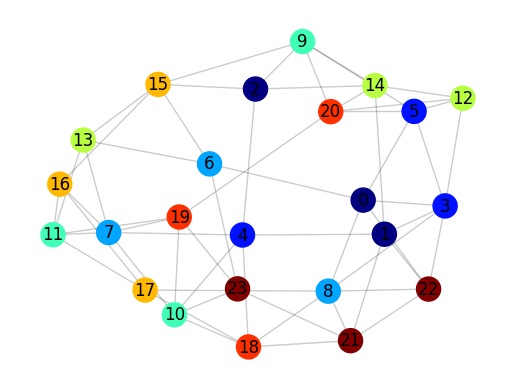

In [121]:
# nodes = df_showcase_normalized.assign(particle_class=df_showcase['particle_class'])
# df_showcase = df_showcase['particle_class']
# df_showcase_normalized = df_showcase_normalized.concat(df_showcase['particle_class'])
G = nx.Graph()
# G.add_nodes_from(df_showcase_normalized)


G.add_edges_from(edges_show)
# 
node_classes = np.array(df_showcase['particle_class'])

for node in G:
    G.nodes[node]['particle_class'] = node_classes[node]
    
print(nx.get_node_attributes(G, 'particle_class'))
particles = set(nx.get_node_attributes(G, 'particle_class').values())
mapping = dict(zip(sorted(particles), count()))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['particle_class']] for n in nodes]

pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, cmap=plt.cm.jet)

lab = nx.draw_networkx_labels(G, pos, font_size=12)
plt.axis('off')
plt.show()


Rysunek przedstawia fragment całego zbudowanego grafu, który zawiera po 3 wierzchołki pochodzące z każdej z klas.

Jak widać na rysunku, wierzchołki jeden klasy nie zawsze są ze sobą połączone, jak na przykład seledynowe (klasa 4). To pokazuje, że gdy tworzymy połączenia między cząstkami na podstawie cosine_simmilarity, to nawet wtedy członkowie jednej klasy mogą się okazać bardziej podobni do członków innej klasy niż do siebie nawzajem.  Sugeruje to, że dane w obrębie jednej klasy nie są do siebie tak podobne jak byśmy się spodziewali. Być może należałoby zbudować graf w inny sposób.

## Graph creation with cosine_similarity

In [122]:


# Separate features and labels
X = df_normalized.values
y = df_empty['particle_class'].values

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(X)

# Define number of neighbors (k)
k = int(np.sqrt(df_normalized.shape[0])/3.)
print(k)

# Create edge list based on top k similarities
edges = []
for i in range(similarity_matrix.shape[0]):
    # Get indices of the top k most similar nodes (excluding itself)
    most_similar = np.argsort(similarity_matrix[i])[-(k + 1):-1]  # Exclude the node itself
    for j in most_similar:
        edges.append([i, j])

40


In [123]:
# Convert edge list to tensor
edge_index = torch.tensor(edges, dtype=torch.int64).t().contiguous()

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create PyTorch Geometric Data object
graph_data = Data(x=X_tensor, edge_index=edge_index, y=y_tensor)

## Training GCN on graph with cosine_similarity

# 

In [124]:
# Initialize the train_mask with zeros (False), indicating that no nodes are part of the training set initially
graph_data.train_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)

# Randomly select 70% of the nodes to be part of the training set
# This is done by sampling without replacement from the range of node indices
# The selected indices are then set to 1 (True) in the train_mask
graph_data.train_mask[random.sample(range(graph_data.num_nodes), int(graph_data.num_nodes * 0.6))] = 1

# Print the unique class labels present in the training set
# This helps to verify that all classes are represented in the training set
print(torch.unique(graph_data.y[graph_data.train_mask]))

# Train the GCN model using the 'train_model' function
# Arguments for the model: input_dim=9, hidden_dim=27, output_dim=9, num_layers=50
# Number of epochs: 1000
model, accuracy_plot, loss_plot = train_model(
    GCN, 
    graph_data, 
    model_args=(9, 27, 9, 12), 
    n_epochs=1000
)

tensor([1, 2, 3, 4, 5, 6, 7, 8])
Epoch 0 | Loss: 2.469 | Accuracy: 17.28%
Epoch 1 | Loss: 2.236 | Accuracy: 23.43%
Epoch 2 | Loss: 2.067 | Accuracy: 26.22%
Epoch 3 | Loss: 1.981 | Accuracy: 28.21%
Epoch 4 | Loss: 1.911 | Accuracy: 29.92%
Epoch 5 | Loss: 1.862 | Accuracy: 30.01%
Epoch 6 | Loss: 1.841 | Accuracy: 28.97%
Epoch 7 | Loss: 1.830 | Accuracy: 28.20%
Epoch 8 | Loss: 1.806 | Accuracy: 28.04%
Epoch 9 | Loss: 1.796 | Accuracy: 29.74%
Epoch 10 | Loss: 1.796 | Accuracy: 31.29%
Epoch 11 | Loss: 1.785 | Accuracy: 31.75%
Epoch 12 | Loss: 1.766 | Accuracy: 32.06%
Epoch 13 | Loss: 1.752 | Accuracy: 32.55%
Epoch 14 | Loss: 1.748 | Accuracy: 32.72%
Epoch 15 | Loss: 1.737 | Accuracy: 32.88%
Epoch 16 | Loss: 1.735 | Accuracy: 32.88%
Epoch 17 | Loss: 1.731 | Accuracy: 32.95%
Epoch 18 | Loss: 1.730 | Accuracy: 32.87%
Epoch 19 | Loss: 1.727 | Accuracy: 32.87%
Epoch 20 | Loss: 1.725 | Accuracy: 32.67%
Epoch 21 | Loss: 1.723 | Accuracy: 32.60%
Epoch 22 | Loss: 1.720 | Accuracy: 33.00%
Epoch 23 | 

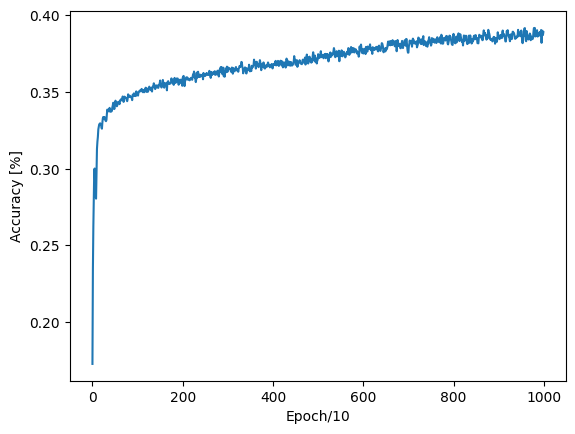

In [125]:
# Plotting accuracy
plt.plot(accuracy_plot)
plt.xlabel('Epoch/10')
plt.ylabel('Accuracy [%]')
plt.show()

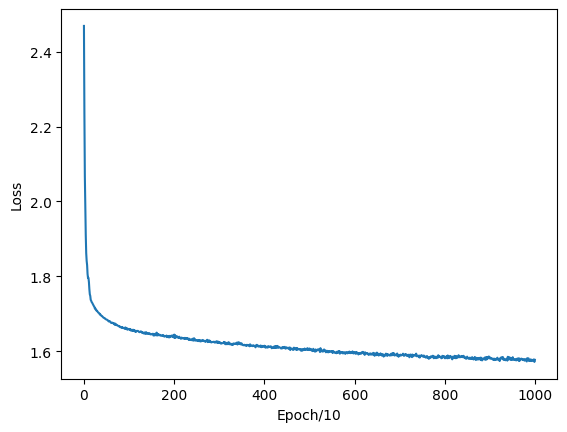

In [126]:
#Plotting loss
plt.plot(loss_plot)
plt.xlabel('Epoch/10')
plt.ylabel('Loss')
plt.show()

Overall Accuracy: 35.99%
              precision    recall  f1-score   support

           1       0.34      0.54      0.41      2426
           2       0.30      0.29      0.29      1828
           3       0.32      0.15      0.21      1388
           4       0.31      0.03      0.06      1082
           5       0.32      0.23      0.27      1986
           6       0.26      0.06      0.10      1473
           7       0.46      0.67      0.55      2212
           8       0.36      0.52      0.42      2202

    accuracy                           0.36     14597
   macro avg       0.33      0.31      0.29     14597
weighted avg       0.34      0.36      0.32     14597



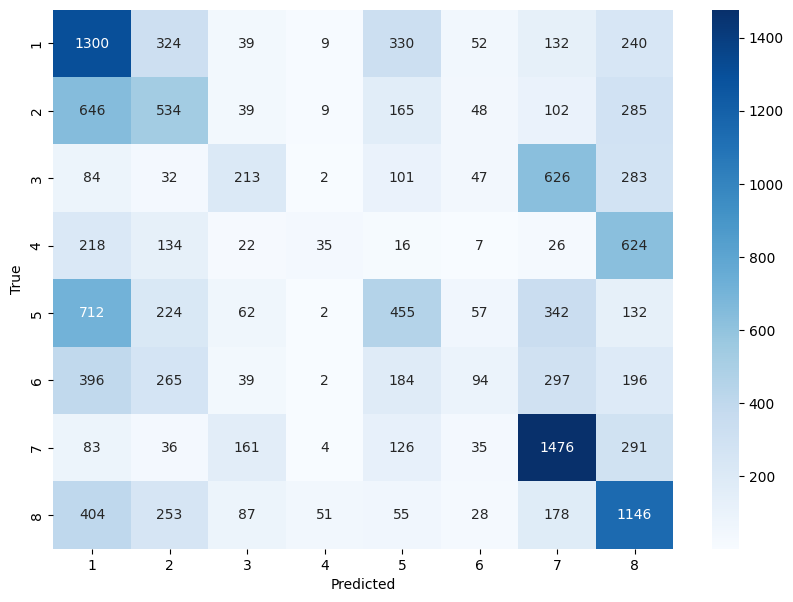

In [127]:
predicted_features = model(graph_data.x.cuda(), graph_data.edge_index.cuda()).cpu().detach().numpy()

# Assuming true labels are available in 'data.y' and predicted labels are available in 'predicted_labels'
true_labels = graph_data.y.cpu().numpy()
predicted_labels = model(graph_data.x.cuda(), graph_data.edge_index.cuda()).argmax(dim=1).cpu().detach().numpy()

overall_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Overall Accuracy: {overall_accuracy:.2%}")

# Calculate class-wise accuracy, precision, recall, and F1 score
class_names = [str(name) for name in df_empty['particle_class'].unique()]
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(class_report)

cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Training GAT on graph with cosine similarity

In [128]:
from sklearn.metrics.pairwise import cosine_similarity

# Separate features and labels
X = df_normalized.values
y = df_empty['particle_class'].values

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(X)

# Define number of neighbors (k)
k = int(np.sqrt(df_normalized.shape[0])/5.)
print(k)

# Create edge list based on top k similarities
edges = []
for i in range(similarity_matrix.shape[0]):
    # Get indices of the top k most similar nodes (excluding itself)
    most_similar = np.argsort(similarity_matrix[i])[-(k + 1):-1]  # Exclude the node itself
    for j in most_similar:
        edges.append([i, j])

24


In [129]:
# Convert edge list to tensor
edge_index = torch.tensor(edges, dtype=torch.int64).t().contiguous()

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create PyTorch Geometric Data object
graph_data = Data(x=X_tensor, edge_index=edge_index, y=y_tensor)

In [130]:
def train_model(
    model_cls: Type[nn.Module],
    graph: Data,
    n_epochs: int = 10,
    model_args = tuple(),
    model_kwargs = dict(),
    *,
    get_optim=lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9),
    get_loss_fn=lambda model: nn.CrossEntropyLoss()
):
    """
    Train the GCN model on the provided graph data.
    
    Args:
        model_cls (Type[nn.Module]): Class of the model to be trained.
        graph (Data): Graph data containing features, edge indices, and labels.
        n_epochs (int, optional): Number of training epochs. Default is 10.
        model_args (tuple, optional): Positional arguments for the model initialization. Default is an empty tuple.
        model_kwargs (dict, optional): Keyword arguments for the model initialization. Default is an empty dictionary.
        get_optim (function, optional): Function that returns the optimizer. Default is Adam optimizer with lr=0.001.
        get_loss_fn (function, optional): Function that returns the loss function. Default is CrossEntropyLoss.
    
    Returns:
        Tuple[nn.Module, list, list]: Trained model, accuracy plot data, and loss plot data.
    """
    # Move the graph data to the GPU
    graph = graph.cuda()
    # Instantiate the model and move it to the GPU
    model = model_cls(*model_args, **model_kwargs).cuda()
    # Get the loss function
    loss_fn = get_loss_fn(model)
    # Get the optimizer
    optimizer = get_optim(model)
    # Lists to store accuracy and loss for plotting
    accuracy_plot = []
    loss_plot = []
    
    # Training loop
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        optimizer.zero_grad()  # Zero the gradients
        out = model(graph.x, graph.edge_index)  # Forward pass
        # Compute the loss for the training set
        loss = loss_fn(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()  # Backward pass
        optimizer.step()  # Update the model parameters
        
        model.eval()  # Set the model to evaluation mode
        # Predict and compute accuracy on the training set
        pred = model(graph.x, graph.edge_index).argmax(dim=1)
        acc = (pred[graph.train_mask] == graph.y[graph.train_mask]).float().mean()
        # Append accuracy and loss for every 10 epochs
        # if epoch % 10 == 0:
        accuracy_plot.append(acc.item())
        loss_plot.append(loss.item())
        print(f"Epoch {epoch} | Loss: {loss.item():.3f} | Accuracy: {acc.item():.2%}")
    
    model.eval()  # Final evaluation mode
    return model, accuracy_plot, loss_plot  # Return the model and plot data

In [131]:
# Initialize the train_mask with zeros (False), indicating that no nodes are part of the training set initially
graph_data.train_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)

# Randomly select 70% of the nodes to be part of the training set
# This is done by sampling without replacement from the range of node indices
# The selected indices are then set to 1 (True) in the train_mask
graph_data.train_mask[random.sample(range(graph_data.num_nodes), int(graph_data.num_nodes * 0.6))] = 1

# Print the unique class labels present in the training set
# This helps to verify that all classes are represented in the training set
print(torch.unique(graph_data.y[graph_data.train_mask]))

# Train the GCN model using the 'train_model' function
# Arguments for the model: input_dim=9, hidden_dim=27, output_dim=9, num_layers=50
# Number of epochs: 1000
model, accuracy_plot, loss_plot = train_model(
    GAT, 
    graph_data, 
    model_args=(9, 27, 9, 12, 3), 
    n_epochs=1000
)

tensor([1, 2, 3, 4, 5, 6, 7, 8])
Epoch 0 | Loss: 3.578 | Accuracy: 19.54%
Epoch 1 | Loss: 2.510 | Accuracy: 19.18%
Epoch 2 | Loss: 8.461 | Accuracy: 19.64%
Epoch 3 | Loss: 18.603 | Accuracy: 19.90%
Epoch 4 | Loss: 9.114 | Accuracy: 18.76%
Epoch 5 | Loss: 5.739 | Accuracy: 20.47%
Epoch 6 | Loss: 3.746 | Accuracy: 21.73%
Epoch 7 | Loss: 2.598 | Accuracy: 25.51%
Epoch 8 | Loss: 2.165 | Accuracy: 29.52%
Epoch 9 | Loss: 2.058 | Accuracy: 28.36%
Epoch 10 | Loss: 2.061 | Accuracy: 26.48%
Epoch 11 | Loss: 2.011 | Accuracy: 26.96%
Epoch 12 | Loss: 1.968 | Accuracy: 30.20%
Epoch 13 | Loss: 1.908 | Accuracy: 29.55%
Epoch 14 | Loss: 1.892 | Accuracy: 26.52%
Epoch 15 | Loss: 1.889 | Accuracy: 25.75%
Epoch 16 | Loss: 1.863 | Accuracy: 27.46%
Epoch 17 | Loss: 1.892 | Accuracy: 24.99%
Epoch 18 | Loss: 1.867 | Accuracy: 24.58%
Epoch 19 | Loss: 1.840 | Accuracy: 27.67%
Epoch 20 | Loss: 1.859 | Accuracy: 27.28%
Epoch 21 | Loss: 1.836 | Accuracy: 27.52%
Epoch 22 | Loss: 1.900 | Accuracy: 28.88%
Epoch 23 |

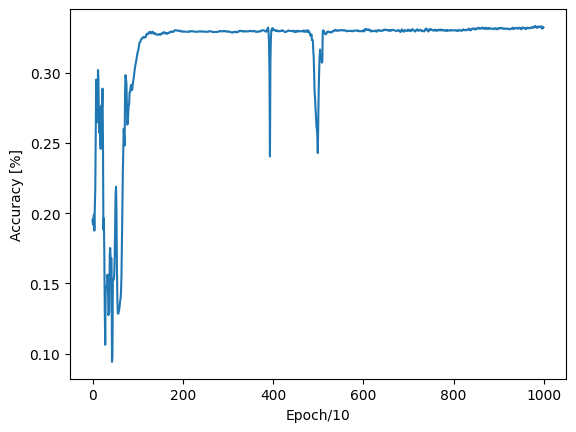

In [132]:
# Plotting accuracy
plt.plot(accuracy_plot)
plt.xlabel('Epoch/10')
plt.ylabel('Accuracy [%]')
plt.show()

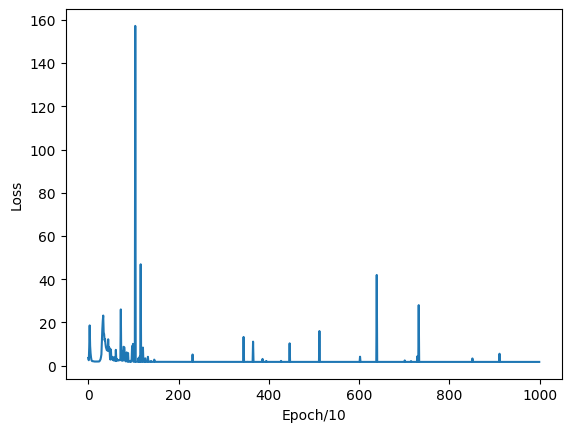

In [133]:
#Plotting loss
plt.plot(loss_plot)
plt.xlabel('Epoch/10')
plt.ylabel('Loss')
plt.show()

Overall Accuracy: 32.73%
              precision    recall  f1-score   support

           1       0.29      0.72      0.41      2426
           2       0.19      0.03      0.05      1828
           3       0.00      0.00      0.00      1388
           4       0.00      0.00      0.00      1082
           5       0.25      0.19      0.21      1986
           6       0.11      0.01      0.02      1473
           7       0.42      0.76      0.54      2212
           8       0.34      0.42      0.38      2202

    accuracy                           0.33     14597
   macro avg       0.20      0.26      0.20     14597
weighted avg       0.23      0.33      0.24     14597



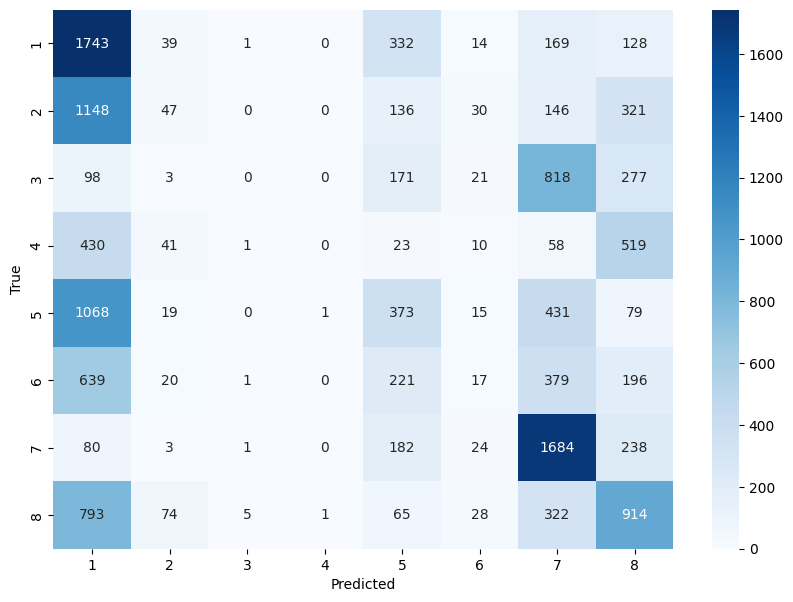

In [134]:
predicted_features = model(graph_data.x.cuda(), graph_data.edge_index.cuda()).cpu().detach().numpy()

# Assuming true labels are available in 'data.y' and predicted labels are available in 'predicted_labels'
true_labels = graph_data.y.cpu().numpy()
predicted_labels = model(graph_data.x.cuda(), graph_data.edge_index.cuda()).argmax(dim=1).cpu().detach().numpy()

overall_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Overall Accuracy: {overall_accuracy:.2%}")

# Calculate class-wise accuracy, precision, recall, and F1 score
class_names = [str(name) for name in df_empty['particle_class'].unique()]
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(class_report)

cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()